In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from pylab import rcParams

rcParams['figure.figsize'] = 20, 6
rcParams['axes.grid'] = True

# Dataset

This dataset contains weather data for New Delhi, India. It was taken out from wunderground with the help of their easy to use api. It contains various features such as temperature, pressure, humidity, rain, precipitation,etc.
The main target is to develop a prediction model accurate enough for predicting the weather. We can try something like predicting the weather in the next 24 hours

In [3]:
data = pd.read_csv('../input/delhi-weather-data/testset.csv')
print(data.shape)
data.head()

(100990, 20)


,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


## Resampling (Hourly)

In [4]:
data['datetime_utc'] = pd.to_datetime(data['datetime_utc'])
data.set_index('datetime_utc', inplace= True)
data =data.resample('H').mean()
data = data[[' _tempm' ]]
data.columns = ['Temp']
print(data.shape)
data.head()

(179504, 1)


,Temp
datetime_utc,
1996-11-01 11:00:00,30.0
1996-11-01 12:00:00,28.0
1996-11-01 13:00:00,24.0
1996-11-01 14:00:00,24.0
1996-11-01 15:00:00,NaN


## Missing Treatment

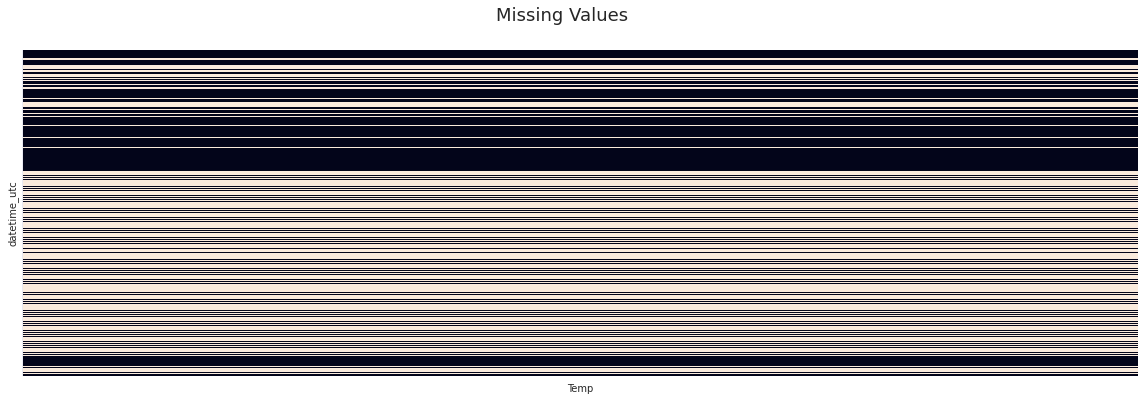

In [5]:
fig, ax = plt.subplots()
sns.heatmap(data.isnull(), cbar=False, yticklabels=False)
fig.suptitle('Missing Values', fontsize=18);

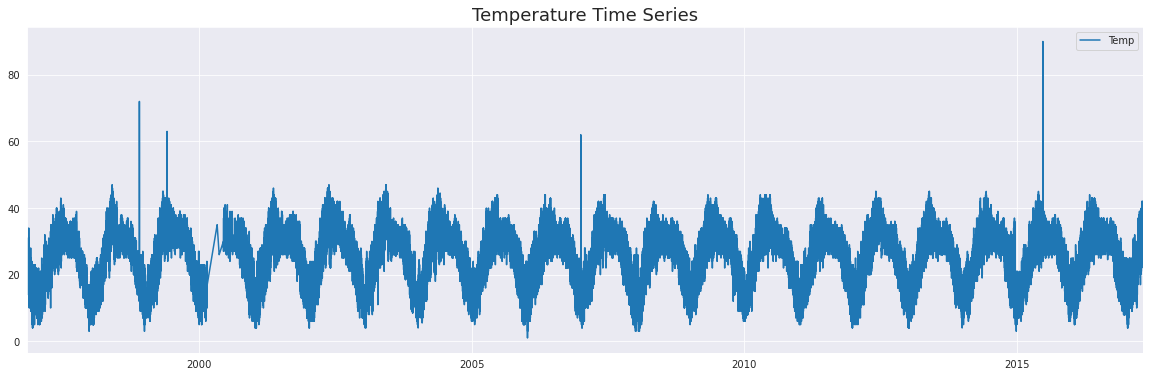

In [6]:
data.interpolate(method='time', inplace=True)
ax = data.plot()
ax.set_title('Temperature Time Series', fontsize=18)
ax.set_xlabel('');

## Seasonal Decomposition

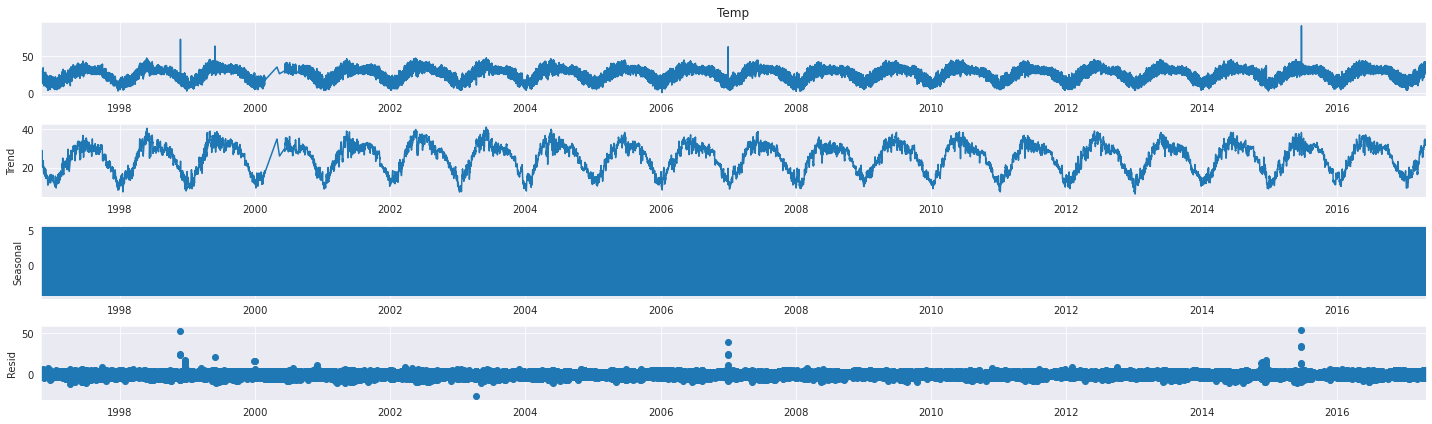

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(data['Temp']).plot();

# Splitting the data

We will train the model on data till 2015 and will evaluate the model on the data for 2016

In [8]:
train = data.iloc[:-(24*7)]
test = data.iloc[-(24*7):]

## Normalize the data
It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages.

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Recurrent neural network
A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

In [10]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential, load_model
from keras.layers import SimpleRNN, LSTM, GRU, Dense 
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model

In [11]:
n_input = 24*7
n_feature = 1

train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=32)

In [12]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
filepath = "model.h5"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1)

An important constructor argument for all keras RNN layers is the return_sequences argument. This setting can configure the layer in one of two ways.

* If False, the default, the layer only returns the output of the final timestep, giving the model time to warm up its internal state before making a single prediction:

![](https://www.tensorflow.org/tutorials/structured_data/images/lstm_1_window.png)

* If True the layer returns an output for each input. This is useful for:
  * Stacking RNN layers.
  * Training a model on multiple timesteps simultaneously.


![](https://www.tensorflow.org/tutorials/structured_data/images/lstm_many_window.png)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 168, 64)           16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 168, 32)           12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 168, 16)           3136      
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 33,257
Trainable params: 33,257
Non-trainable params: 0
_________________________________________________________________


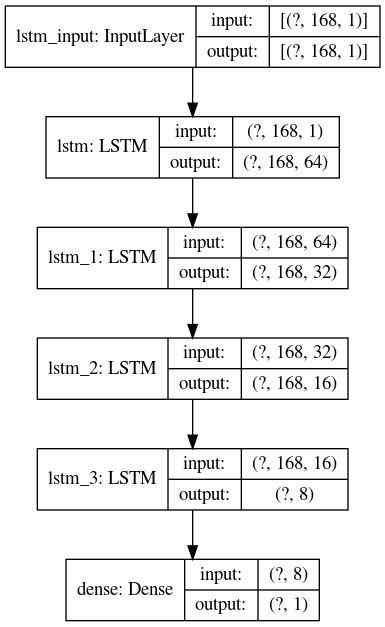

In [13]:
model = Sequential()

model.add(LSTM(64, input_shape= (n_input, n_feature), return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16, return_sequences=True))
model.add(LSTM(8, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()
plot_model(model, show_shapes=True)

Epoch 1/100
5599/5599 [==============================] - ETA: 0s - loss: 0.0513
Epoch 00001: loss improved from inf to 0.05132, saving model to model.h5
5599/5599 [==============================] - 126s 23ms/step - loss: 0.0513
Epoch 2/100
5599/5599 [==============================] - ETA: 0s - loss: 0.0106
Epoch 00002: loss improved from 0.05132 to 0.01055, saving model to model.h5
5599/5599 [==============================] - 127s 23ms/step - loss: 0.0106
Epoch 3/100
5599/5599 [==============================] - ETA: 0s - loss: 0.0098
Epoch 00003: loss improved from 0.01055 to 0.00984, saving model to model.h5
5599/5599 [==============================] - 127s 23ms/step - loss: 0.0098
Epoch 4/100
5599/5599 [==============================] - ETA: 0s - loss: 0.0094
Epoch 00004: loss improved from 0.00984 to 0.00937, saving model to model.h5
5599/5599 [==============================] - 127s 23ms/step - loss: 0.0094
Epoch 5/100
5599/5599 [==============================] - ETA: 0s - loss: 0.0

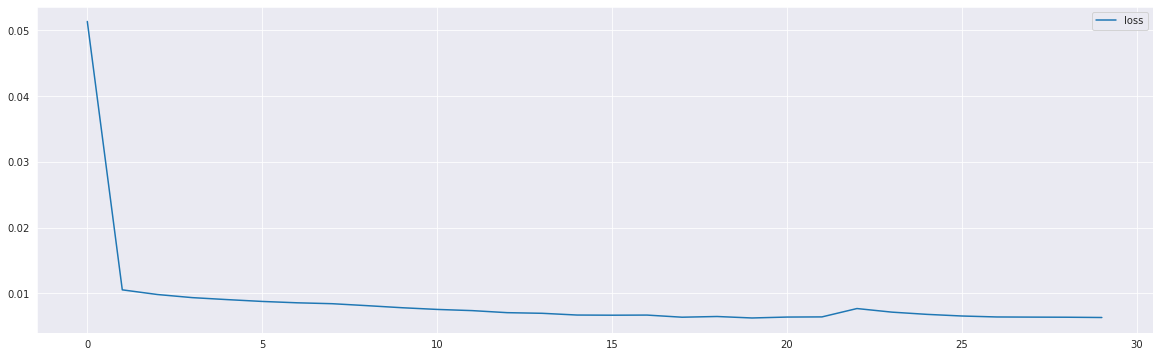

In [14]:
history = model.fit_generator(train_generator, callbacks=[es, ckpt, rlp], epochs=100)
pd.DataFrame(history.history)[['loss']].plot();

# Model Evaluation

In [15]:
model = load_model('model.h5')

test_predictions = []
current_batch = scaled_train[-n_input:].reshape((1,n_input,n_feature))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis= 1)

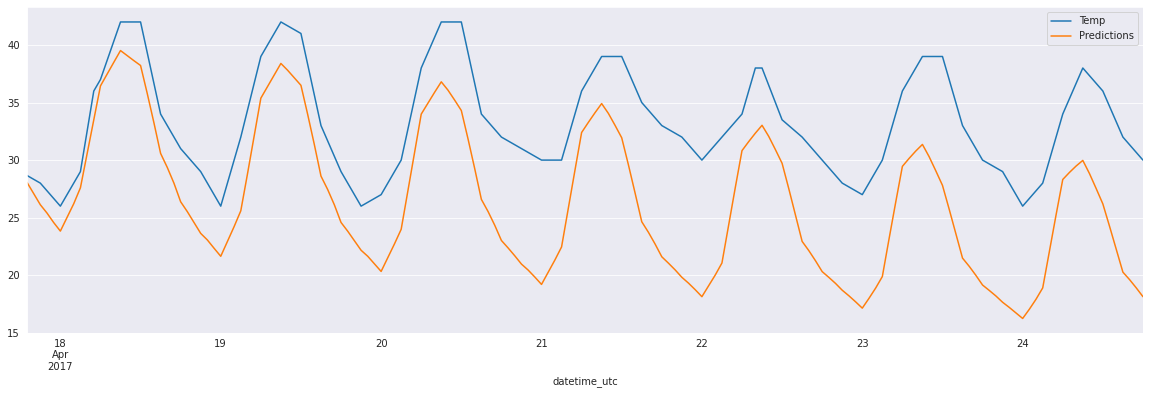

In [16]:
test['Predictions'] = scaler.inverse_transform(test_predictions)
test.plot();

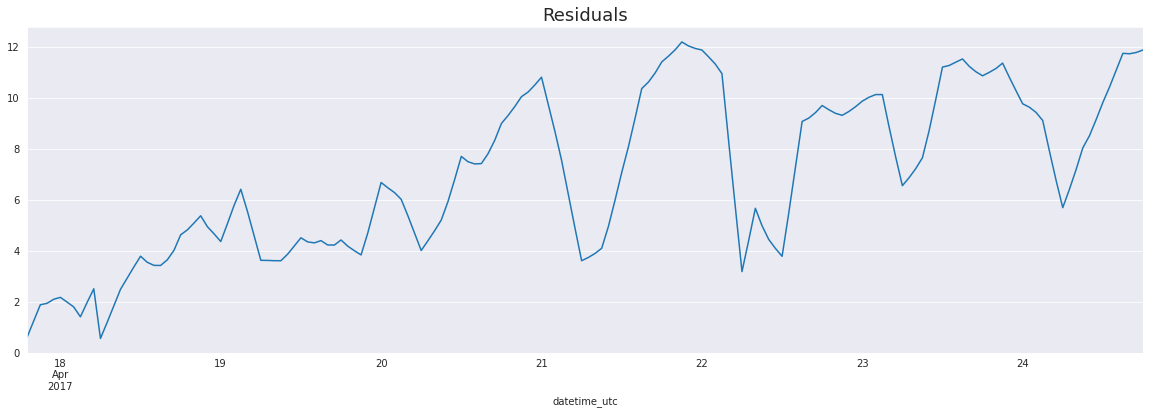

In [17]:
test['Residuals'] = test['Temp'] - test['Predictions']
ax = test['Residuals'].plot()
ax.set_title('Residuals', fontsize=18);

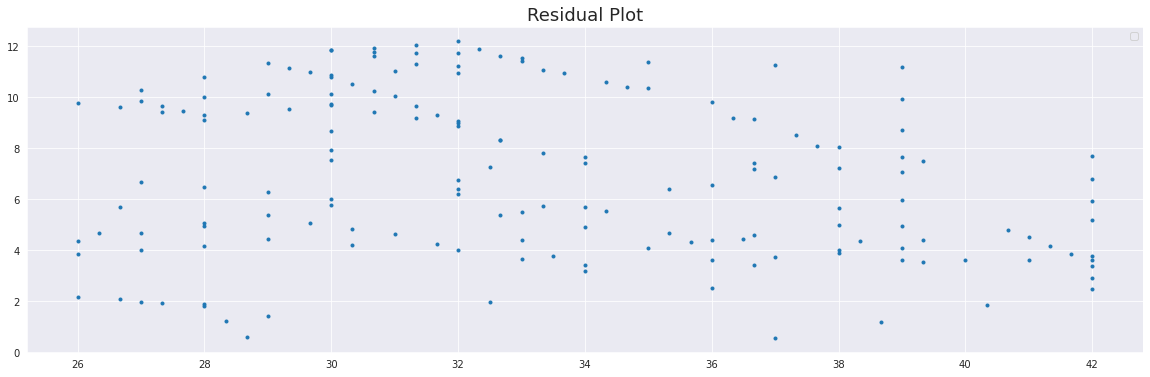

In [18]:
fig, ax = plt.subplots()
ax.plot(test['Temp'].values, test['Residuals'].values, '.')
ax.set_title('Residual Plot', fontsize=18)
ax.legend();

Although we used one week data as test set, but we would like to predict only one day into future, therefore from that perspective our model is performing very well